In [1]:
import os, sys, random, math
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
import itertools as it
import scipy
import glob

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader
from torch.optim import Optimizer
import torchvision.transforms.transforms as txf
import torch.optim.lr_scheduler as lr_scheduler
from collections import OrderedDict

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import radam
import torch_utils

In [2]:
BATCH_SIZE = 256
NUM_WORKERS = 4
MULT = 2

device = "cuda" if torch.cuda.is_available() else "cpu" 

In [3]:
torch_utils.seed_everything(947)

In [4]:
class MyData(Dataset):
    def __init__(self, X, y=None, transforms=None):
        self.X = X
        self.y = y
        self.transforms = transforms
        if y is not None:
            assert len(y)==len(X)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        img = np.array(self.X.iloc[idx,:], dtype='uint8').reshape(28,28)
        if self.transforms is not None:
            img = self.transforms(img)
        
        if self.y is not None:
            y = np.zeros(10, dtype="float32")
            y[self.y.iloc[idx]] = 1
            return img, y
        return img

In [5]:
train_transforms = txf.Compose([
    txf.ToPILImage(),
    txf.RandomAffine(degrees=7, translate=(0.3,0.3), scale=(0.8, 1.2), shear=7),
    txf.ToTensor(),
    txf.Normalize([0.485], [0.229])
])

test_transforms = txf.Compose([
    txf.ToPILImage(),
    txf.ToTensor(),
    txf.Normalize([0.485], [0.229])
])

In [6]:
train_df = pd.read_csv("./train.csv")
test_df = pd.read_csv("./test.csv")
dig_df = pd.read_csv("./Dig-MNIST.csv")
sub_df = pd.read_csv("./sample_submission.csv")

In [7]:
target = train_df["label"]
train_df.drop("label", axis=1, inplace=True)
test_df.drop("id", axis=1, inplace=True)

In [8]:
X_train, X_valid, y_train, y_valid = train_test_split(train_df, target, stratify=target, random_state=947, test_size=0.025)

In [9]:
len(X_train), len(X_valid)

(58500, 1500)

In [10]:
dataset_train = MyData(X_train, y_train, train_transforms)
dataset_valid = MyData(X_valid, y_valid, test_transforms)
dataset_test = MyData(test_df, transforms=test_transforms)

In [11]:
train_loader = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
valid_loader = DataLoader(dataset_valid, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
test_loader = DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

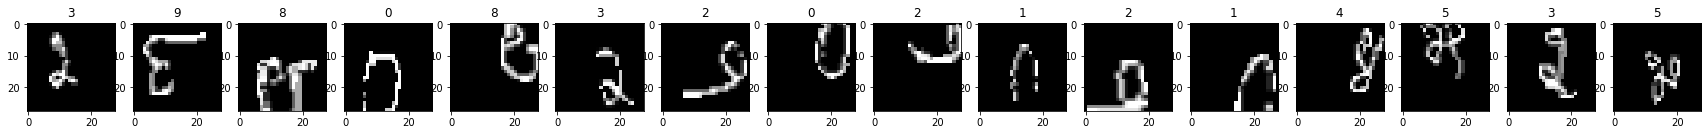

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=16, figsize=(30,4))

for batch in train_loader:
    for i in range(16):
        ax[i].set_title(batch[1][i].data.numpy().argmax())
        ax[i].imshow(batch[0][i, 0], cmap="gray")
    break

In [13]:
class Network(nn.Module):
    def __init__(self, n_classes):
        super(Network, self).__init__()
        self.conv1 = torch_utils.CNNLayer(1, MULT*32)
        self.conv2 = torch_utils.CNNLayer(MULT*32, MULT*32)
        self.conv3 = torch_utils.CNNLayer(MULT*32, MULT*32)
        self.conv4 = torch_utils.CNNLayer(MULT*32, MULT*32)
        
        self.conv5 = torch_utils.CNNLayer(MULT*32, MULT*64)
        self.conv6 = torch_utils.CNNLayer(MULT*64, MULT*64)
        self.conv7 = torch_utils.CNNLayer(MULT*64, MULT*64)
        self.conv8 = torch_utils.CNNLayer(MULT*64, MULT*64)
        self.conv9 = torch_utils.CNNLayer(MULT*64, MULT*64)
        self.conv10 = torch_utils.CNNLayer(MULT*64, MULT*64)
        
        self.maxpool = nn.MaxPool2d(2, 2)
        
        self.fc1 = torch_utils.FCLayer(MULT*64*7*7, MULT*512)
        self.fc2 = torch_utils.FCLayer(MULT*512, MULT*512)
        self.fc3 = torch_utils.FCLayer(MULT*512, MULT*512)
        self.fc4 = torch_utils.FCLayer(MULT*512, MULT*512)
        
        self.out = nn.Linear(MULT*512, n_classes)
    
    def forward(self, x):
        if isinstance(x, list):
            x, shuffle, lmbda = x
        else:
            shuffle = None
            lmbda = None
        
        mixing_layer = np.random.randint(15)
        
        x = torch_utils.manifold_mixup(x, shuffle, lmbda, 0, mixing_layer)
        x = self.conv1(x)
        x = torch_utils.manifold_mixup(x, shuffle, lmbda, 1, mixing_layer)
        x = self.conv2(x)
        x = torch_utils.manifold_mixup(x, shuffle, lmbda, 2, mixing_layer)
        x = self.conv3(x)
        x = torch_utils.manifold_mixup(x, shuffle, lmbda, 3, mixing_layer)
        x = self.conv4(x)
        x = self.maxpool(x)
        x = torch_utils.manifold_mixup(x, shuffle, lmbda, 4, mixing_layer)
        x = self.conv5(x)
        x = torch_utils.manifold_mixup(x, shuffle, lmbda, 5, mixing_layer)
        x = self.conv6(x)
        x = torch_utils.manifold_mixup(x, shuffle, lmbda, 6, mixing_layer)
        x = self.conv7(x)
        x = torch_utils.manifold_mixup(x, shuffle, lmbda, 7, mixing_layer)
        x = self.conv8(x)
        x = torch_utils.manifold_mixup(x, shuffle, lmbda, 8, mixing_layer)
        x = self.conv9(x)
        x = torch_utils.manifold_mixup(x, shuffle, lmbda, 9, mixing_layer)
        x = self.conv10(x)
        x = self.maxpool(x)
        x = x.view(x.size(0), -1)
        x = torch_utils.manifold_mixup(x, shuffle, lmbda, 10, mixing_layer)
        x = self.fc1(x)
        x = torch_utils.manifold_mixup(x, shuffle, lmbda, 11, mixing_layer)
        x = self.fc2(x)
        x = torch_utils.manifold_mixup(x, shuffle, lmbda, 12, mixing_layer)
        x = self.fc3(x)
        x = torch_utils.manifold_mixup(x, shuffle, lmbda, 13, mixing_layer)
        x = self.fc4(x)
        x = torch_utils.manifold_mixup(x, shuffle, lmbda, 14, mixing_layer)
        return self.out(x)

In [14]:
def mixup_txf(data, target):
    alpha = 2
    lmbda = np.random.beta(alpha, alpha)
    shuffle = torch.randperm(data.size(0))
    target = lmbda*target+(1-lmbda)*target[shuffle]
    return [data, shuffle, lmbda], target

In [15]:
model = Network(10)
model = model.to(device)
n_epochs = 60
criterion = torch_utils.one_hot_cross_entropy
optimizer = radam.RAdam(model.parameters(), lr=0.05)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=n_epochs // 10, gamma=0.25)

In [16]:
import time

training_history = pd.DataFrame()

for epoch in range(n_epochs):
    curt = time.time()
    torch_utils.clear_cuda()
    
    print("Learning Rate: {}".format(torch_utils.get_lr(optimizer)))
    
    train_loss, train_acc = torch_utils.train_classifier(model,optimizer,criterion,1+epoch,train_loader,
                                 device=device, print_interval=100, custom_txf=mixup_txf, one_hot=True)
    valid_loss, valid_acc = torch_utils.test_classifier(model, criterion, device, valid_loader, one_hot=True)
    training_history.loc[epoch, "train_loss"] = train_loss
    training_history.loc[epoch, "valid_loss"] = valid_loss
    training_history.loc[epoch, "train_accuracy"] = train_acc
    training_history.loc[epoch, "valid_accuracy"] = valid_acc
    print("Epoch {} time: {} seconds\n\n".format(epoch+1, time.time()-curt))
    
    exp_lr_scheduler.step()

Learning Rate: 0.05
Train Epoch: 1 [0/58500 (0.00000000%)]	Loss: 2.51194191
Train Epoch: 1 [25600/58500 (43.66812227%)]	Loss: 1.26651454
Train Epoch: 1 [51200/58500 (87.33624454%)]	Loss: 1.40726209
Train Set: Average loss: 1.38224050, Accuracy: 39650/58500 (67.77777778%)

Test set: Average loss: 0.00387282, Accuracy: 1092/1500 (72.80000000%)

Epoch 1 time: 21.284568548202515 seconds


Learning Rate: 0.05
Train Epoch: 2 [0/58500 (0.00000000%)]	Loss: 0.89226842
Train Epoch: 2 [25600/58500 (43.66812227%)]	Loss: 1.08004022
Train Epoch: 2 [51200/58500 (87.33624454%)]	Loss: 0.77494699
Train Set: Average loss: 0.91914242, Accuracy: 47493/58500 (81.18461538%)

Test set: Average loss: 0.00122234, Accuracy: 1455/1500 (97.00000000%)

Epoch 2 time: 21.262964725494385 seconds


Learning Rate: 0.05
Train Epoch: 3 [0/58500 (0.00000000%)]	Loss: 0.89641148
Train Epoch: 3 [25600/58500 (43.66812227%)]	Loss: 0.76603949
Train Epoch: 3 [51200/58500 (87.33624454%)]	Loss: 0.74879128
Train Set: Average loss: 0

Train Epoch: 22 [0/58500 (0.00000000%)]	Loss: 0.89883411
Train Epoch: 22 [25600/58500 (43.66812227%)]	Loss: 0.58118719
Train Epoch: 22 [51200/58500 (87.33624454%)]	Loss: 0.56555766
Train Set: Average loss: 0.61013460, Accuracy: 53720/58500 (91.82905983%)

Test set: Average loss: 0.00018116, Accuracy: 1499/1500 (99.93333333%)

Epoch 22 time: 21.90157961845398 seconds


Learning Rate: 0.00078125
Train Epoch: 23 [0/58500 (0.00000000%)]	Loss: 0.45888406
Train Epoch: 23 [25600/58500 (43.66812227%)]	Loss: 0.45952544
Train Epoch: 23 [51200/58500 (87.33624454%)]	Loss: 0.63043207
Train Set: Average loss: 0.60611622, Accuracy: 54058/58500 (92.40683761%)

Test set: Average loss: 0.00024541, Accuracy: 1500/1500 (100.00000000%)

Epoch 23 time: 22.725196838378906 seconds


Learning Rate: 0.00078125
Train Epoch: 24 [0/58500 (0.00000000%)]	Loss: 0.41126910
Train Epoch: 24 [25600/58500 (43.66812227%)]	Loss: 0.67146188
Train Epoch: 24 [51200/58500 (87.33624454%)]	Loss: 0.67765892
Train Set: Average loss

Train Set: Average loss: 0.60352284, Accuracy: 53864/58500 (92.07521368%)

Test set: Average loss: 0.00021089, Accuracy: 1500/1500 (100.00000000%)

Epoch 42 time: 22.35376477241516 seconds


Learning Rate: 3.0517578125e-06
Train Epoch: 43 [0/58500 (0.00000000%)]	Loss: 0.47117531
Train Epoch: 43 [25600/58500 (43.66812227%)]	Loss: 0.52427089
Train Epoch: 43 [51200/58500 (87.33624454%)]	Loss: 0.61746335
Train Set: Average loss: 0.59904686, Accuracy: 54121/58500 (92.51452991%)

Test set: Average loss: 0.00016417, Accuracy: 1500/1500 (100.00000000%)

Epoch 43 time: 22.546926498413086 seconds


Learning Rate: 3.0517578125e-06
Train Epoch: 44 [0/58500 (0.00000000%)]	Loss: 0.52341473
Train Epoch: 44 [25600/58500 (43.66812227%)]	Loss: 0.49096376
Train Epoch: 44 [51200/58500 (87.33624454%)]	Loss: 0.65495479
Train Set: Average loss: 0.58278611, Accuracy: 53826/58500 (92.01025641%)

Test set: Average loss: 0.00009744, Accuracy: 1500/1500 (100.00000000%)

Epoch 44 time: 22.378790140151978 seconds



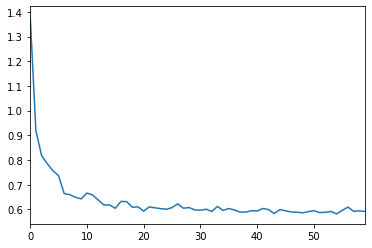

In [17]:
training_history["train_loss"].plot()

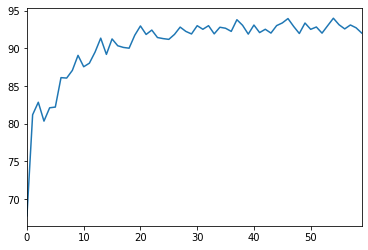

In [18]:
training_history["train_accuracy"].plot()

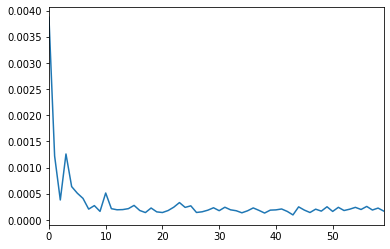

In [19]:
training_history["valid_loss"].plot()

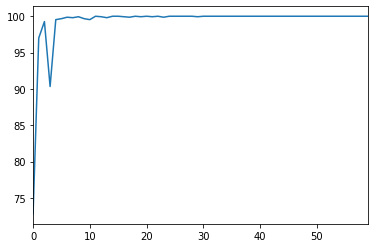

In [20]:
training_history["valid_accuracy"].plot()

In [21]:
preds = []
for x in test_loader:
    y_pred = model(x.to(device))
    y_pred = y_pred.argmax(dim=1)
    preds.extend(y_pred.cpu().numpy())

In [22]:
sub_df["label"] = pd.Series(preds)

In [23]:
sub_df.to_csv("submission.csv", index=False)

In [24]:
sub_df

,id,label
0,0,3
1,1,0
2,2,2
3,3,6
4,4,7
...,...,...
4995,4995,1
4996,4996,1
4997,4997,1
4998,4998,6


In [25]:
torch.save(model.state_dict(), "RADAM_Manifold.pt")